In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import uniform

from sklearn.model_selection import train_test_split
from sklearn.metrics import PrecisionRecallDisplay, mutual_info_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve, classification_report, make_scorer
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier

from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier 
from sklearn.preprocessing import MinMaxScaler

#from featurewiz import FeatureWiz

import h2o
from h2o.automl import H2OAutoML

import shap
shap.initjs()




In [69]:
data_descriptions = pd.read_csv("data/data_descriptions.csv")
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [62]:
data_descriptions

,Column_name,Column_type,Data_type,Description
0,AccountAge,Feature,integer,The age of the user's account in months.
1,MonthlyCharges,Feature,float,The amount charged to the user on a monthly ba...
2,TotalCharges,Feature,float,The total charges incurred by the user over th...
3,SubscriptionType,Feature,object,The type of subscription chosen by the user (B...
4,PaymentMethod,Feature,string,The method of payment used by the user.
5,PaperlessBilling,Feature,string,Indicates whether the user has opted for paper...
6,ContentType,Feature,string,The type of content preferred by the user (Mov...
7,MultiDeviceAccess,Feature,string,Indicates whether the user has access to the s...
8,DeviceRegistered,Feature,string,"The type of device registered by the user (TV,..."
9,ViewingHoursPerWeek,Feature,float,The number of hours the user spends watching c...


In [22]:
train.head()


,AccountAge,MonthlyCharges,TotalCharges,SubscriptionType,PaymentMethod,PaperlessBilling,ContentType,MultiDeviceAccess,DeviceRegistered,ViewingHoursPerWeek,...,ContentDownloadsPerMonth,GenrePreference,UserRating,SupportTicketsPerMonth,Gender,WatchlistSize,ParentalControl,SubtitlesEnabled,CustomerID,Churn
0,20,11.055215,221.104302,Premium,Mailed check,No,Both,No,Mobile,36.758104,...,10,Sci-Fi,2.176498,4,Male,3,No,No,CB6SXPNVZA,0
1,57,5.175208,294.986882,Basic,Credit card,Yes,Movies,No,Tablet,32.450568,...,18,Action,3.478632,8,Male,23,No,Yes,S7R2G87O09,0
2,73,12.106657,883.785952,Basic,Mailed check,Yes,Movies,No,Computer,7.395160,...,23,Fantasy,4.238824,6,Male,1,Yes,Yes,EASDC20BDT,0
3,32,7.263743,232.439774,Basic,Electronic check,No,TV Shows,No,Tablet,27.960389,...,30,Drama,4.276013,2,Male,24,Yes,Yes,NPF69NT69N,0
4,57,16.953078,966.325422,Premium,Electronic check,Yes,TV Shows,No,TV,20.083397,...,20,Comedy,3.616170,4,Female,0,No,No,4LGYPK7VOL,0


In [23]:
test.head()

,AccountAge,MonthlyCharges,TotalCharges,SubscriptionType,PaymentMethod,PaperlessBilling,ContentType,MultiDeviceAccess,DeviceRegistered,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,GenrePreference,UserRating,SupportTicketsPerMonth,Gender,WatchlistSize,ParentalControl,SubtitlesEnabled,CustomerID
0,38,17.869374,679.036195,Premium,Mailed check,No,TV Shows,No,TV,29.126308,122.274031,42,Comedy,3.522724,2,Male,23,No,No,O1W6BHP6RM
1,77,9.912854,763.289768,Basic,Electronic check,Yes,TV Shows,No,TV,36.873729,57.093319,43,Action,2.021545,2,Female,22,Yes,No,LFR4X92X8H
2,5,15.019011,75.095057,Standard,Bank transfer,No,TV Shows,Yes,Computer,7.601729,140.414001,14,Sci-Fi,4.806126,2,Female,22,No,Yes,QM5GBIYODA
3,88,15.357406,1351.451692,Standard,Electronic check,No,Both,Yes,Tablet,35.586430,177.002419,14,Comedy,4.943900,0,Female,23,Yes,Yes,D9RXTK2K9F
4,91,12.406033,1128.949004,Standard,Credit card,Yes,TV Shows,Yes,Tablet,23.503651,70.308376,6,Drama,2.846880,6,Female,0,No,No,ENTCCHR1LR


### Problem Description
This project focuses on predicting customer churn prediction for a subscription-based service. Customer churn, the rate at which customers cancel their subscriptions, is a vital metric for businesses offering subscription services. ML techniques are employed to anticipate which customers are likely to churn, enabling companies to take proactive measures for customer retention.

Problem is described in README with enough context, so it's clear what the problem is and how the solution will be used.

### EDA

Extensive EDA (ranges of values, missing values, analysis of target variable, feature importance analysis)



In [24]:
train.describe()

,AccountAge,MonthlyCharges,TotalCharges,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,UserRating,SupportTicketsPerMonth,WatchlistSize,Churn
count,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000,243787.000000
mean,60.083758,12.490695,750.741017,20.502179,92.264061,24.503513,3.002713,4.504186,12.018508,0.181232
std,34.285143,4.327615,523.073273,11.243753,50.505243,14.421174,1.155259,2.872548,7.193034,0.385211
min,1.000000,4.990062,4.991154,1.000065,5.000547,0.000000,1.000007,0.000000,0.000000,0.000000
25%,30.000000,8.738543,329.147027,10.763953,48.382395,12.000000,2.000853,2.000000,6.000000,0.000000
50%,60.000000,12.495555,649.878487,20.523116,92.249992,24.000000,3.002261,4.000000,12.000000,0.000000
75%,90.000000,16.238160,1089.317362,30.219396,135.908048,37.000000,4.002157,7.000000,18.000000,0.000000
max,119.000000,19.989957,2378.723844,39.999723,179.999275,49.000000,4.999989,9.000000,24.000000,1.000000


- Looks like on average, users have been subscribed from 5 years
- On average, users are viewing for 20 hours/week
- On average, users are viewing for 1.5 hours per session

No glaring outliers in the data.

In [7]:
# missing values
display(train.isna().sum())
test.isna().sum()

AccountAge                  0
MonthlyCharges              0
TotalCharges                0
SubscriptionType            0
PaymentMethod               0
PaperlessBilling            0
ContentType                 0
MultiDeviceAccess           0
DeviceRegistered            0
ViewingHoursPerWeek         0
AverageViewingDuration      0
ContentDownloadsPerMonth    0
GenrePreference             0
UserRating                  0
SupportTicketsPerMonth      0
Gender                      0
WatchlistSize               0
ParentalControl             0
SubtitlesEnabled            0
CustomerID                  0
Churn                       0
dtype: int64

AccountAge                  0
MonthlyCharges              0
TotalCharges                0
SubscriptionType            0
PaymentMethod               0
PaperlessBilling            0
ContentType                 0
MultiDeviceAccess           0
DeviceRegistered            0
ViewingHoursPerWeek         0
AverageViewingDuration      0
ContentDownloadsPerMonth    0
GenrePreference             0
UserRating                  0
SupportTicketsPerMonth      0
Gender                      0
WatchlistSize               0
ParentalControl             0
SubtitlesEnabled            0
CustomerID                  0
dtype: int64

In [70]:
# removing customerID as it is not useful for predicting churn
train.drop(columns=['CustomerID'], inplace=True)
test.drop(columns=['CustomerID'], inplace=True)

In [9]:
# converting data types
train.dtypes

AccountAge                    int64
MonthlyCharges              float64
TotalCharges                float64
SubscriptionType             object
PaymentMethod                object
PaperlessBilling             object
ContentType                  object
MultiDeviceAccess            object
DeviceRegistered             object
ViewingHoursPerWeek         float64
AverageViewingDuration      float64
ContentDownloadsPerMonth      int64
GenrePreference              object
UserRating                  float64
SupportTicketsPerMonth        int64
Gender                       object
WatchlistSize                 int64
ParentalControl              object
SubtitlesEnabled             object
Churn                         int64
dtype: object

In [10]:
train.PaperlessBilling.unique(), train.MultiDeviceAccess.unique(), train.ParentalControl.unique(), train.SubtitlesEnabled.unique(), train.Gender.unique()

(array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['No', 'Yes'], dtype=object),
 array(['Male', 'Female'], dtype=object))

In [64]:
categorical_features = ['SubscriptionType','PaymentMethod','ContentType','DeviceRegistered','GenrePreference', 'PaperlessBilling',
                        'MultiDeviceAccess','ParentalControl','SubtitlesEnabled','Gender']
def mutual_info_price_score(series):
    return round(mutual_info_score(series, train.Churn),6)

train[categorical_features].apply(mutual_info_price_score)

SubscriptionType     0.000658
PaymentMethod        0.000498
ContentType          0.000089
DeviceRegistered     0.000006
GenrePreference      0.000348
PaperlessBilling     0.000000
MultiDeviceAccess    0.000001
ParentalControl      0.000015
SubtitlesEnabled     0.000077
Gender               0.000028
dtype: float64

In [65]:
numerical_features = train.columns[~train.dtypes.isin(['object'])]
numerical_features
# deleting churn
#numerical_features = numerical_features.delete(-1)

# Feature importance with ROC AUC score
auc_score_dict = {}
# For each numerical variable, use it as score and compute AUC with the above_average variable
for col in numerical_features:
    check_auc = roc_auc_score(train.Churn, train[col])
    
    # AUC can go below 0.5 if the variable is negatively correlated with the target varialble.
    # You can change the direction of the correlation by negating this variable - then
    # negative correlation becomes positive.
    if check_auc < 0.5:
        auc_score_dict[col] = roc_auc_score(train.Churn, -train[col])
    else:
        auc_score_dict[col] = check_auc

auc_score_dict

{'AccountAge': 0.6481599568568046,
 'MonthlyCharges': 0.5753011535748791,
 'TotalCharges': 0.5982486784356418,
 'ViewingHoursPerWeek': 0.5963999482019857,
 'AverageViewingDuration': 0.6100916203259076,
 'ContentDownloadsPerMonth': 0.5972136548833826,
 'UserRating': 0.5165797079397941,
 'SupportTicketsPerMonth': 0.5626840751419275,
 'WatchlistSize': 0.5162774415621321,
 'Churn': 1.0}

<Axes: >

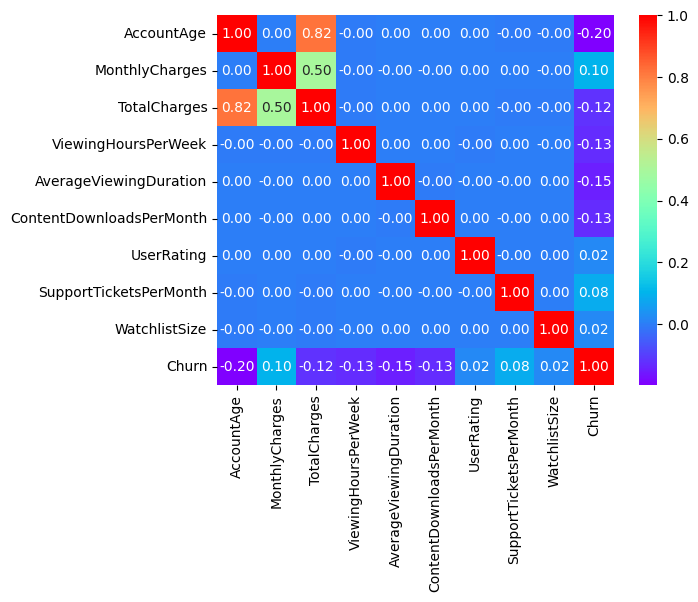

In [40]:
#numerical_features = train.columns[train.dtypes.isin(['int64','float64'])]

# correlation plot to see how numerical features affect churn
sns.heatmap(train[numerical_features].corr(), annot=True, cmap= 'rainbow',fmt='.2f') 


Individually, categorical and numerical features do not seem to affect churn from mutual score info and correlation plot. ROC AUC score importances suggest that account age's effect is better than that of other features.


In [71]:
# seeing how many examples for churn case
train.Churn.value_counts()

Churn
0    199605
1     44182
Name: count, dtype: int64

There are 4.5 times more non-churn examples than churn examples and as expected there's a class imbalance problem to be dealt.

### Validation framework

In [72]:
# splitting train data into train, val sets with 80%, 20% data
df_train, df_val = train_test_split(train, test_size=0.2, random_state=1)
len(df_train), len(df_val), len(train)

(195029, 48758, 243787)

In [73]:
y_train = df_train.Churn.values
y_val = df_val.Churn.values

y_train_series = df_train.Churn
y_val_series = df_val.Churn

del df_train['Churn']
del df_val['Churn']

y_train_lab = y_train.astype(object)
y_val_lab = y_val.astype(object)
y_val_lab


array([0, 0, 0, ..., 0, 0, 0], dtype=object)

In [74]:
# one hot encoding the categorical variables
dv = DictVectorizer(sparse=False)
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [45]:
print(X_val)

  (0, 0)	45.0
  (0, 1)	97.62686105446262
  (0, 2)	8.0
  (0, 3)	1.0
  (0, 9)	1.0
  (0, 10)	1.0
  (0, 13)	1.0
  (0, 17)	9.57229975982066
  (0, 19)	1.0
  (0, 20)	1.0
  (0, 22)	1.0
  (0, 26)	1.0
  (0, 29)	1.0
  (0, 31)	1.0
  (0, 33)	0.0
  (0, 34)	430.7534891919297
  (0, 35)	3.9912675767035632
  (0, 36)	23.104580843427325
  (0, 37)	16.0
  (1, 0)	71.0
  (1, 1)	95.83101801386236
  (1, 2)	21.0
  (1, 5)	1.0
  (1, 7)	1.0
  (1, 11)	1.0
  :	:
  (48756, 32)	1.0
  (48756, 33)	1.0
  (48756, 34)	903.8277761133704
  (48756, 35)	1.901618267934492
  (48756, 36)	30.031339040162926
  (48756, 37)	24.0
  (48757, 0)	103.0
  (48757, 1)	118.6786497744264
  (48757, 2)	34.0
  (48757, 5)	1.0
  (48757, 8)	1.0
  (48757, 10)	1.0
  (48757, 14)	1.0
  (48757, 17)	9.28277278279656
  (48757, 19)	1.0
  (48757, 21)	1.0
  (48757, 23)	1.0
  (48757, 26)	1.0
  (48757, 28)	1.0
  (48757, 31)	1.0
  (48757, 33)	0.0
  (48757, 34)	956.1255966280456
  (48757, 35)	2.7346073474923944
  (48757, 36)	10.137878077249969
  (48757, 37)	6.0


### baseline model

In [54]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.7500538897881953

In [55]:
churn_decision_threshold = (y_pred >= 0.5)
print(classification_report(y_true=y_val, y_pred=churn_decision_threshold, target_names=['no_churn','churn']))

              precision    recall  f1-score   support

    no_churn       0.83      0.98      0.90     39961
       churn       0.56      0.11      0.19      8797

    accuracy                           0.82     48758
   macro avg       0.70      0.55      0.55     48758
weighted avg       0.79      0.82      0.77     48758



- Our baseline model (logistic regression) gives a poor f1 score and accuracy is meaningless in this case even though it is high.
- Since there is class imbalance and assuming that the business benefits much more from minimizing False Negatives (predicting a customer doesn't churn when he/she churns) recall and f1 should be the metrics to focus on. 

In [48]:
h2o.init()


Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,32 mins 35 secs
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.1
H2O_cluster_version_age:,"14 days, 22 hours and 22 minutes"
H2O_cluster_name:,H2O_from_python_avanjavakam_akw1gy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.573 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [70]:
X_y_train_h = h2o.H2OFrame(pd.concat([df_train, y_train_series], axis='columns'))
X_y_train_h['Churn'] = X_y_train_h['Churn'].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [72]:
X_y_val_h = h2o.H2OFrame(pd.concat([df_val, y_val_series], axis='columns'))
X_y_val_h['Churn'] = X_y_val_h['Churn'].asfactor()
test_h = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [73]:
X_y_train_h.describe()

Rows:195029
Cols:20

,AccountAge,MonthlyCharges,TotalCharges,SubscriptionType,PaymentMethod,PaperlessBilling,ContentType,MultiDeviceAccess,DeviceRegistered,ViewingHoursPerWeek,AverageViewingDuration,ContentDownloadsPerMonth,GenrePreference,UserRating,SupportTicketsPerMonth,Gender,WatchlistSize,ParentalControl,SubtitlesEnabled,Churn
type,int,real,real,enum,enum,enum,enum,enum,enum,real,real,int,enum,real,int,enum,int,enum,enum,enum
mins,1.0,4.990184837049273,4.991154354368685,,,,,,,1.000065389097874,5.002643094661178,0.0,,1.0000073778257992,0.0,,0.0,,,
mean,60.037861036050856,12.492007319539217,750.0923874157795,,,,,,,20.533100831447076,92.21046967557025,24.504212194083912,,3.0032782124572237,4.505422270534137,,12.028523963102923,,,
maxs,119.0,19.9899568673232,2378.723844106135,,,,,,,39.99972313614872,179.99927511771548,49.0,,4.999989412151973,9.0,,24.0,,,
sigma,34.25287958404601,4.326046557205015,522.2205794268616,,,,,,,11.238595601917945,50.495390494019794,14.418482226757957,,1.1549034571151782,2.872808356321208,,7.189828605853668,,,
zeros,0,0,0,,,,,,,0,0,3869,,0,19391,,7661,,,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,82.0,17.35608569917113,1423.1990273320323,Premium,Bank transfer,No,Movies,Yes,Computer,1.9043371126299096,85.64900311563042,40.0,Sci-Fi,2.0028539845951947,4.0,Female,7.0,No,No,1
1,3.0,16.003500491291298,48.01050147387389,Basic,Credit card,Yes,Both,No,Tablet,20.26426311458447,12.65217767063228,46.0,Action,1.729659542498514,5.0,Male,5.0,No,No,0
2,35.0,9.353606643805756,327.3762325332014,Basic,Electronic check,Yes,Movies,No,TV,39.425779885606296,13.602254986147893,24.0,Action,2.933178354905976,2.0,Female,14.0,No,No,0


In [62]:
y = "Churn"
x = list(df_train)
x

['AccountAge',
 'MonthlyCharges',
 'TotalCharges',
 'SubscriptionType',
 'PaymentMethod',
 'PaperlessBilling',
 'ContentType',
 'MultiDeviceAccess',
 'DeviceRegistered',
 'ViewingHoursPerWeek',
 'AverageViewingDuration',
 'ContentDownloadsPerMonth',
 'GenrePreference',
 'UserRating',
 'SupportTicketsPerMonth',
 'Gender',
 'WatchlistSize',
 'ParentalControl',
 'SubtitlesEnabled']

### Model Training

Train multiple models and tune their parameters

In [92]:
aml = H2OAutoML(max_models=25, max_runtime_secs_per_model=30, seed=1, project_name='churn_prediction', stopping_metric='AUCPR', 
                balance_classes=True, nfolds = -1, sort_metric = 'AUCPR', verbosity = "info") #export_checkpoints_dir = "auto_ml_models"
%time aml.train(x=x, y=y, training_frame=X_y_train_h, leaderboard_frame = X_y_val_h)

AutoML progress: |█
17:22:17.956: Project: churn_prediction
17:22:17.961: 5-fold cross-validation will be used.
17:22:17.962: Setting stopping tolerance adaptively based on the training frame: 0.002264385697150918
17:22:17.962: Build control seed: 1
17:22:17.965: training frame: Frame key: AutoML_1_20231031_172217_training_py_2_sid_99b5    cols: 20    rows: 195029  chunks: 9    size: 9756861  checksum: -346280610830517794
17:22:17.965: validation frame: NULL
17:22:17.967: leaderboard frame: Frame key: py_3_sid_99b5    cols: 20    rows: 48758  chunks: 3    size: 2445498  checksum: 963657877374908300
17:22:17.967: blending frame: NULL
17:22:17.967: response column: Churn
17:22:17.967: fold column: null
17:22:17.967: weights column: null
17:22:17.988: AutoML: XGBoost is not available; skipping it.
17:22:17.997: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (7g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w)

Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_2_AutoML_2_20231103_115115


GLM Model: summary
    family    link    regularization               lambda_search                                                                    number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  ---------------------------  -------------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  -----------------------------------------------
    binomial  logit   Ridge ( lambda = 2.137E-4 )  nlambda = 30, lambda.max = 7.6118, lambda.min = 2.137E-4, lambda.1se = 0.009659  38                            38                             39                      AutoML_2_20231103_115115_training_py_2_sid_99b5

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.12942530986804837
RMSE: 0.3597572930018909
LogLoss: 0.4116977929209072
AUC: 0.7503540154822437
AUCPR: 0.4046733540396579
Gini: 0.5007080309644873
Null degrees of freedom: 195028
Residual degrees of freedom: 194990
Null deviance: 184716.5744522471
Residual deviance: 160586.0177111432
AIC: 160664.0177111432

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.216801616961624
       0       1      Error    Rate
-----  ------  -----  -------  ------------------
0      119991  39653  0.2484   (39653.0/159644.0)
1      13886   21499  0.3924   (13886.0/35385.0)
Total  133877  61152  0.2745   (53539.0/195029.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.216802     0.445404  227
max f2                       0.116804     0.590452  304
max f0point5                 0.324785     0.423557  158
max accuracy                 0.502393     0.824411  75
max precision                0.868932     1         0
max recall                   0.00757771   1         399
max specificity              0.868932     1         0
max absolute_mcc             0.231986     0.2993    216
max min_per_class_accuracy   0.18482      0.683032  250
max mean_per_class_accuracy  0.172722     0.684803  259
max tns                      0.868932     159644    0
max fns                      0.868932     35383     0
max fps                      0.00757771   159644    399
max tps                      0.00757771   35385     399
max tnr                      0.868932     1         0
max fnr                      0.868932     0.999943  0
max fpr                      0.00757771   1         399
max tpr                      0.00757771   1         399

Gains/Lift Table: Avg response rate: 18.14 %, avg score: 18.14 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100036                   0.617511           3.64711   3.64711            0.661712         0.678815   0.661712                    0.678815            0.0364844       0.0364844                  264.711   264.711            0.0323502
2        0.0200022                   0.562142           3.18827   3.41775            0.578462         0.587218   0.620097                    0.633029            0.0318779       0.0683623                  218.827   241.775            0.0590791
3        0.0300007                   0.524194           2.99041   3.27533            0.542564         0.542681   0.594257                    0.602918            0.0298997   

In [93]:
# View the AutoML Leaderboard
lb = h2o.automl.get_leaderboard(aml, extra_columns = "ALL")
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

model_id,aucpr,auc,logloss,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
GLM_2_AutoML_2_20231103_115115,0.398926,0.750046,0.410716,0.321327,0.359482,0.129228,787,0.000575,GLM
GLM_1_AutoML_1_20231031_172217,0.398926,0.750046,0.410716,0.321327,0.359482,0.129228,1865,0.00036,GLM
StackedEnsemble_BestOfFamily_1_AutoML_1_20231031_172217,0.398138,0.74963,0.411002,0.322933,0.359608,0.129318,40655,0.018012,StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_1_20231031_172217,0.398112,0.74961,0.411136,0.323053,0.359666,0.12936,52007,0.020233,StackedEnsemble
DeepLearning_2_AutoML_2_20231103_115115,0.396826,0.748275,0.413133,0.318727,0.360786,0.130167,6401,0.002631,DeepLearning
DeepLearning_1_AutoML_1_20231031_172217,0.396807,0.747697,0.412989,0.320868,0.360697,0.130102,5552,0.002693,DeepLearning
DeepLearning_grid_2_AutoML_1_20231031_172217_model_2,0.394979,0.746557,0.424832,0.323395,0.364021,0.132511,1037,0.004408,DeepLearning
DeepLearning_grid_6_AutoML_2_20231103_115115_model_2,0.394929,0.747353,0.431769,0.323226,0.36856,0.135837,1119,0.00577,DeepLearning
DeepLearning_grid_6_AutoML_2_20231103_115115_model_3,0.393793,0.743819,0.416447,0.329391,0.361562,0.130727,474,0.004862,DeepLearning
DeepLearning_grid_3_AutoML_1_20231031_172217_model_2,0.39346,0.746561,0.418374,0.322825,0.362951,0.131734,1528,0.005928,DeepLearning


# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
GLM_2_AutoML_2_20231103_115115,0.750046,0.410716,0.398926,0.321327,0.359482,0.129228,787,0.000562,GLM
GLM_1_AutoML_1_20231031_172217,0.750046,0.410716,0.398926,0.321327,0.359482,0.129228,1865,0.000508,GLM
StackedEnsemble_BestOfFamily_1_AutoML_1_20231031_172217,0.74963,0.411002,0.398138,0.322933,0.359608,0.129318,40655,0.019067,StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_1_20231031_172217,0.74961,0.411136,0.398112,0.323053,0.359666,0.12936,52007,0.023763,StackedEnsemble
DeepLearning_2_AutoML_2_20231103_115115,0.748275,0.413133,0.396826,0.318727,0.360786,0.130167,6401,0.002652,DeepLearning
DeepLearning_grid_6_AutoML_2_20231103_115115_model_1,0.74824,0.415762,0.393381,0.320201,0.361732,0.13085,2404,0.012801,DeepLearning
DeepLearning_1_AutoML_1_20231031_172217,0.747697,0.412989,0.396807,0.320868,0.360697,0.130102,5552,0.002656,DeepLearning
DeepLearning_grid_6_AutoML_2_20231103_115115_model_2,0.747353,0.431769,0.394929,0.323226,0.36856,0.135837,1119,0.005686,DeepLearning
DeepLearning_grid_3_AutoML_1_20231031_172217_model_1,0.747124,0.412807,0.390503,0.32789,0.360617,0.130045,2326,0.012993,DeepLearning
DeepLearning_grid_5_AutoML_2_20231103_115115_model_1,0.746847,0.414036,0.389272,0.323574,0.361067,0.130369,2053,0.0082,DeepLearning


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GLM_2_AutoML_2_20231103_115115

,0,1,Error,Rate
0,30079.0,9882.0,0.2473,(9882.0/39961.0)
1,3478.0,5319.0,0.3954,(3478.0/8797.0)
Total,33557.0,15201.0,0.274,(13360.0/48758.0)


# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

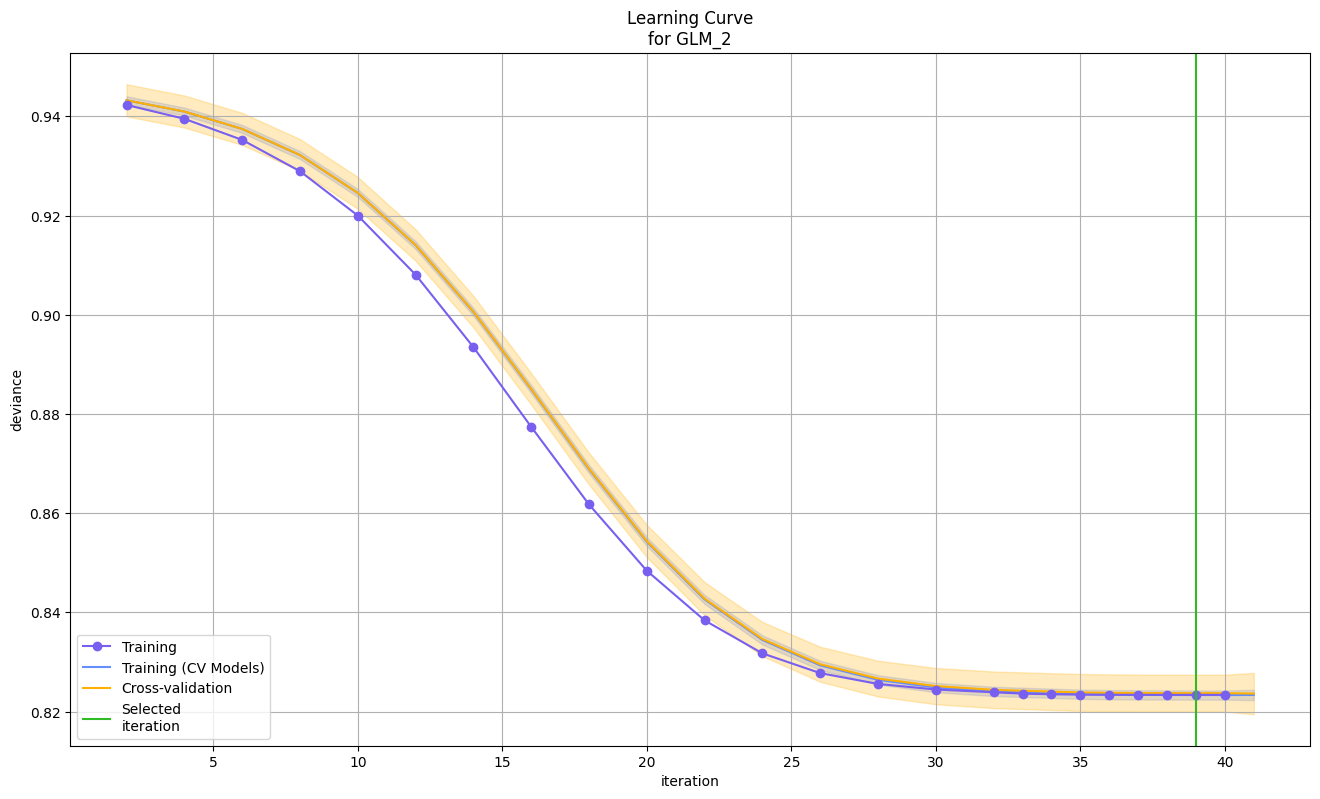

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

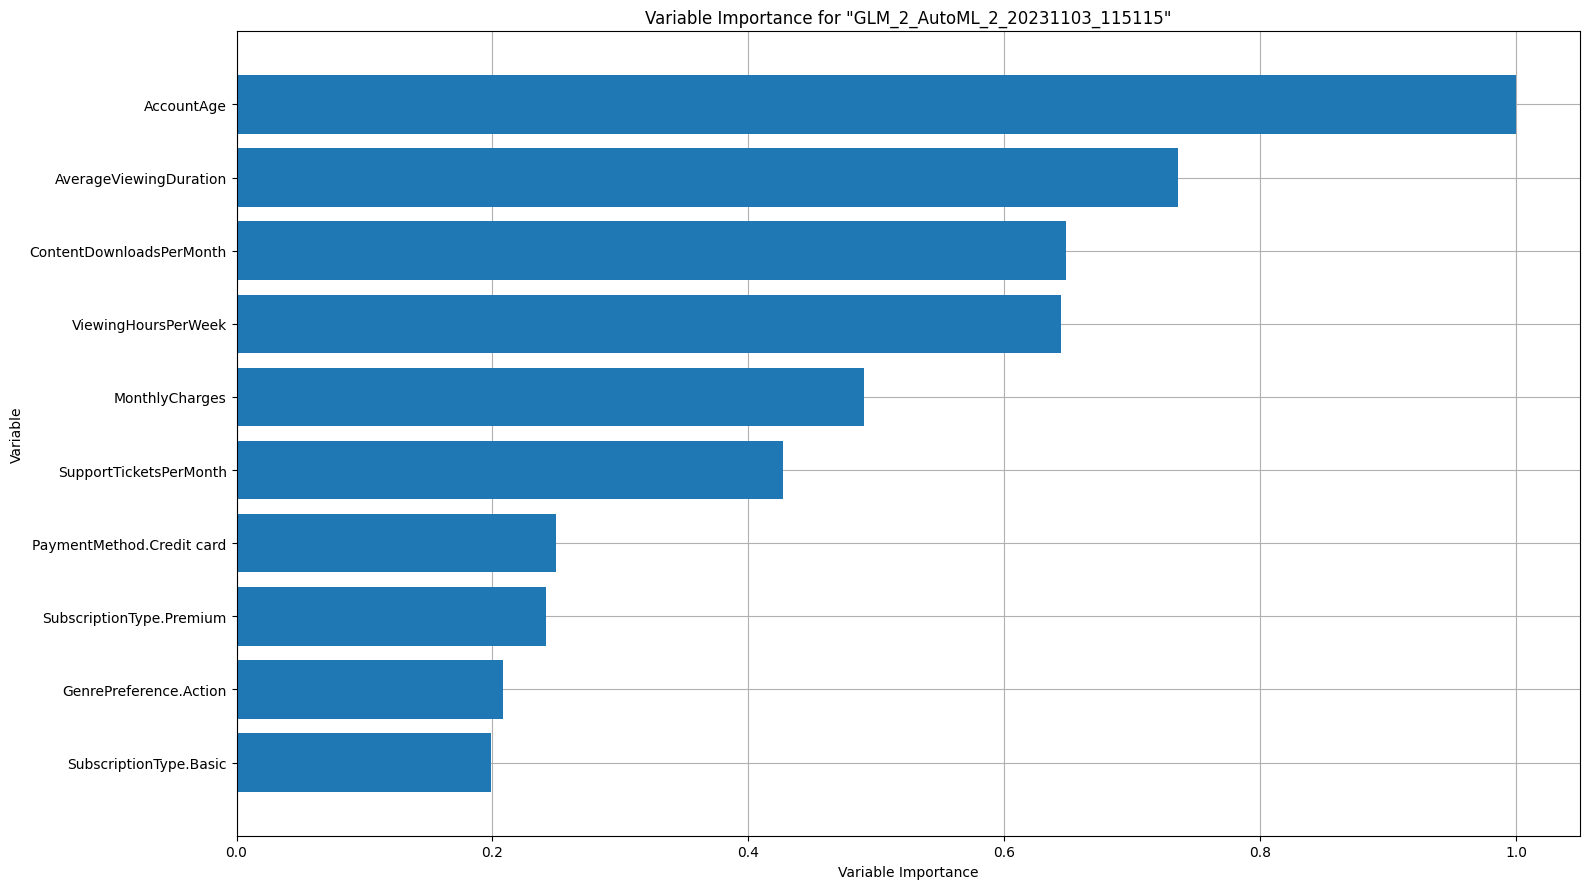

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

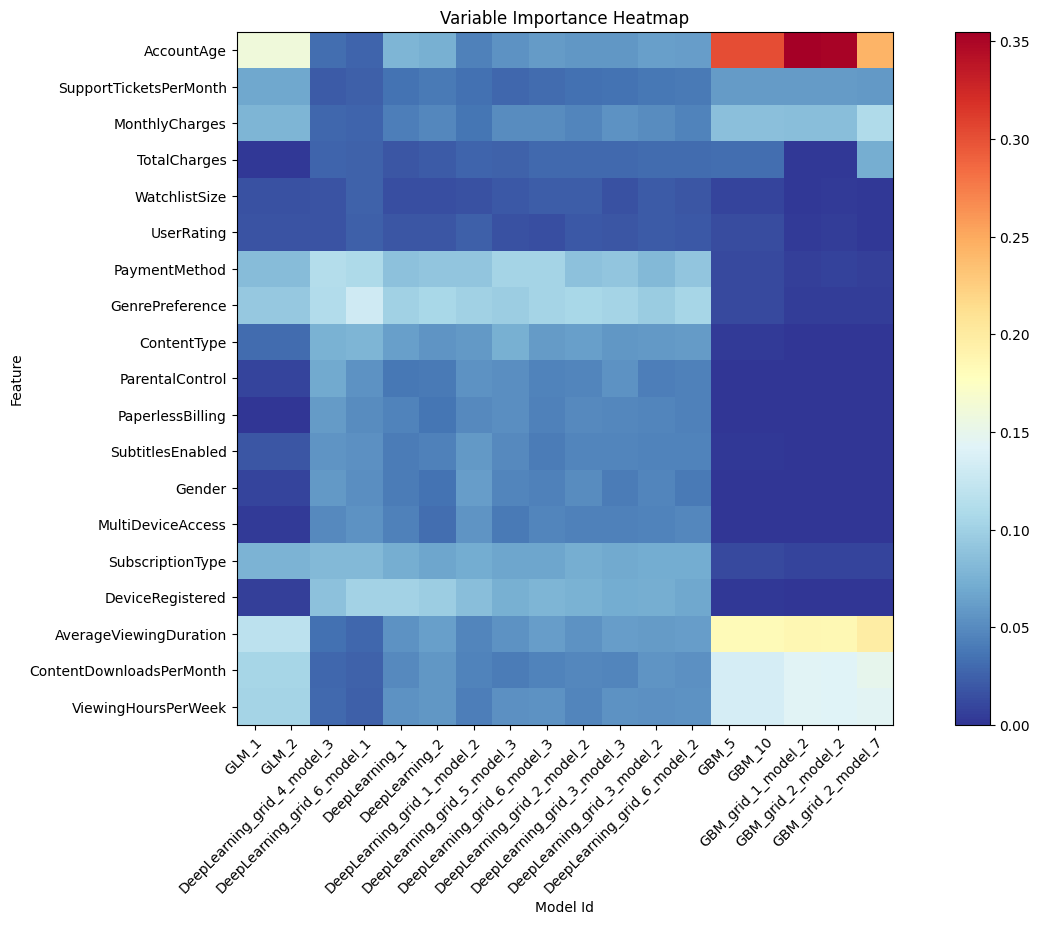

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

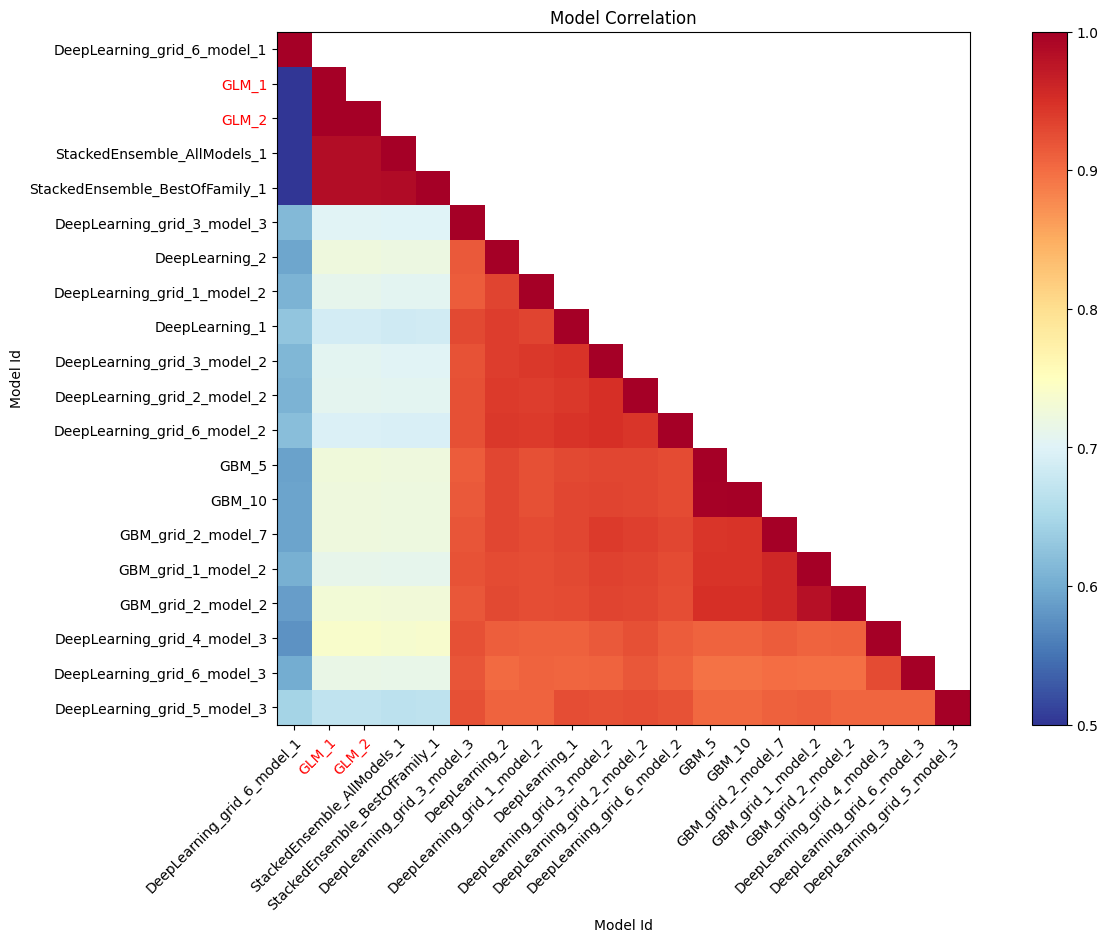

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

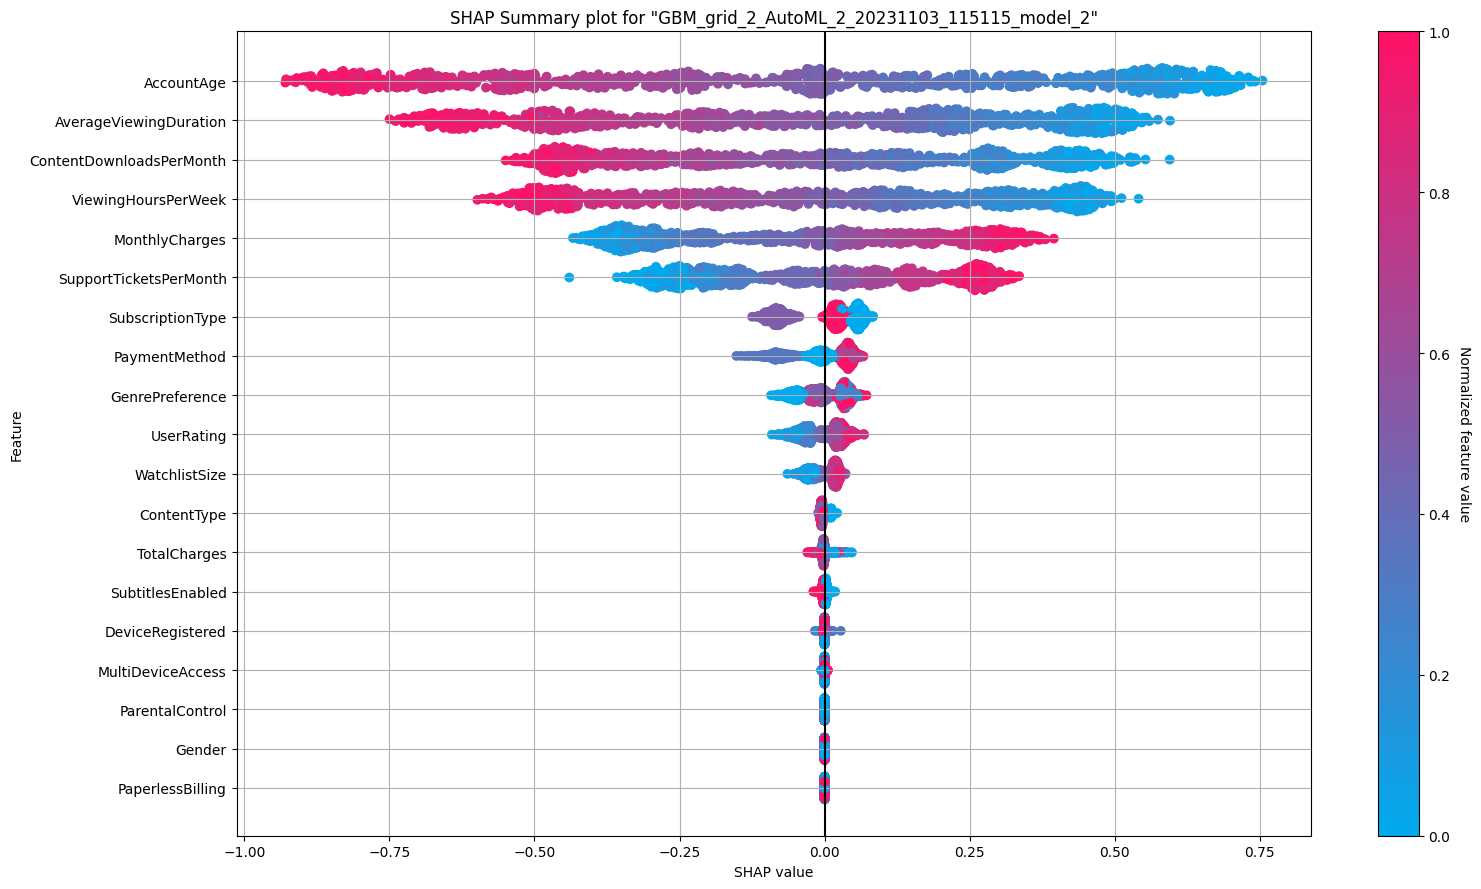

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

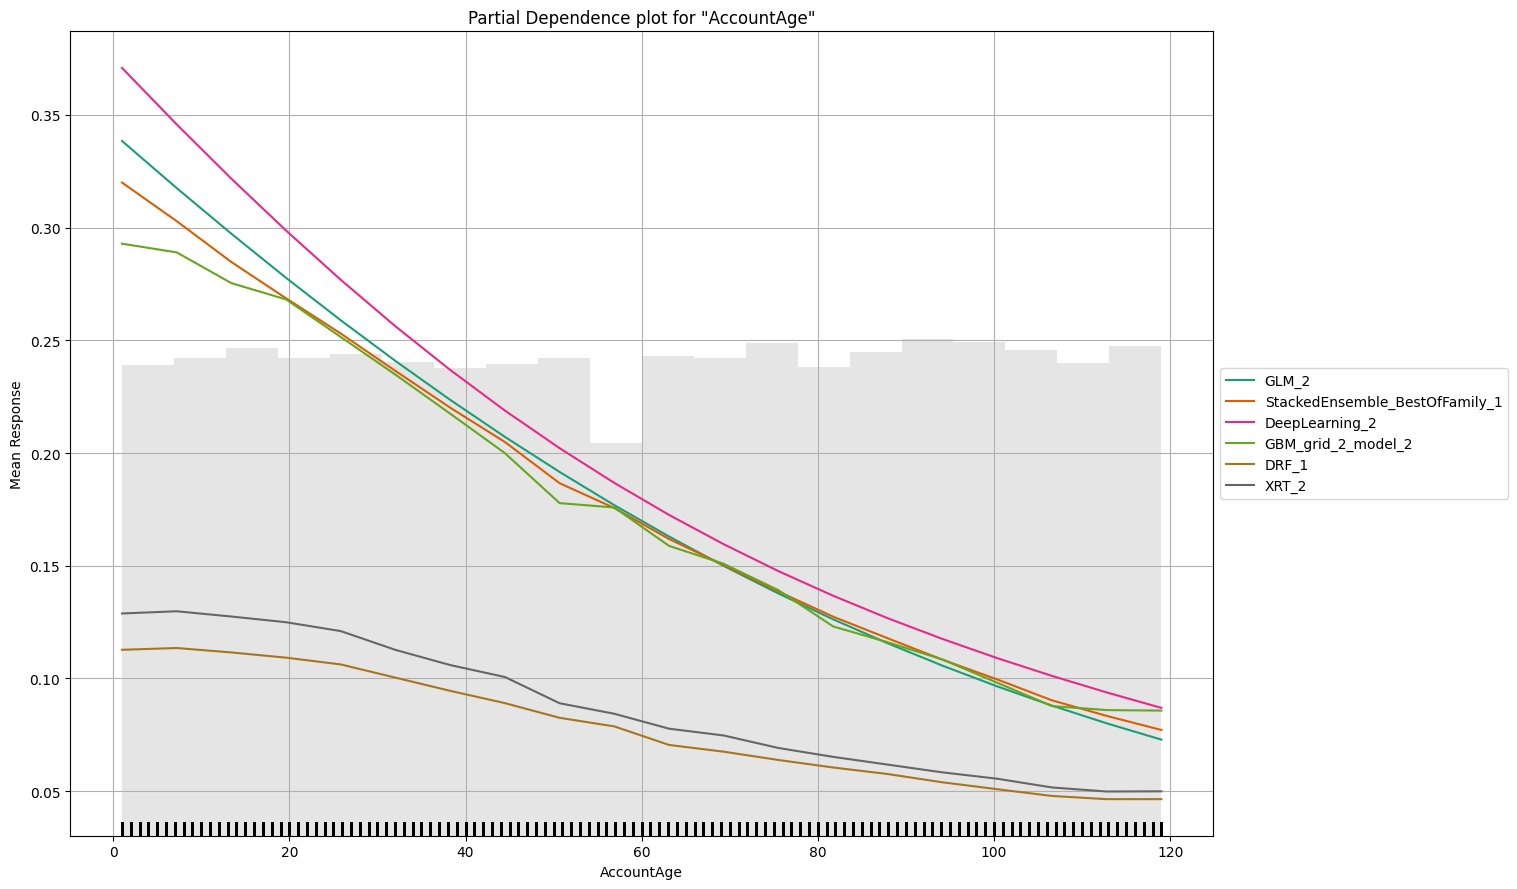

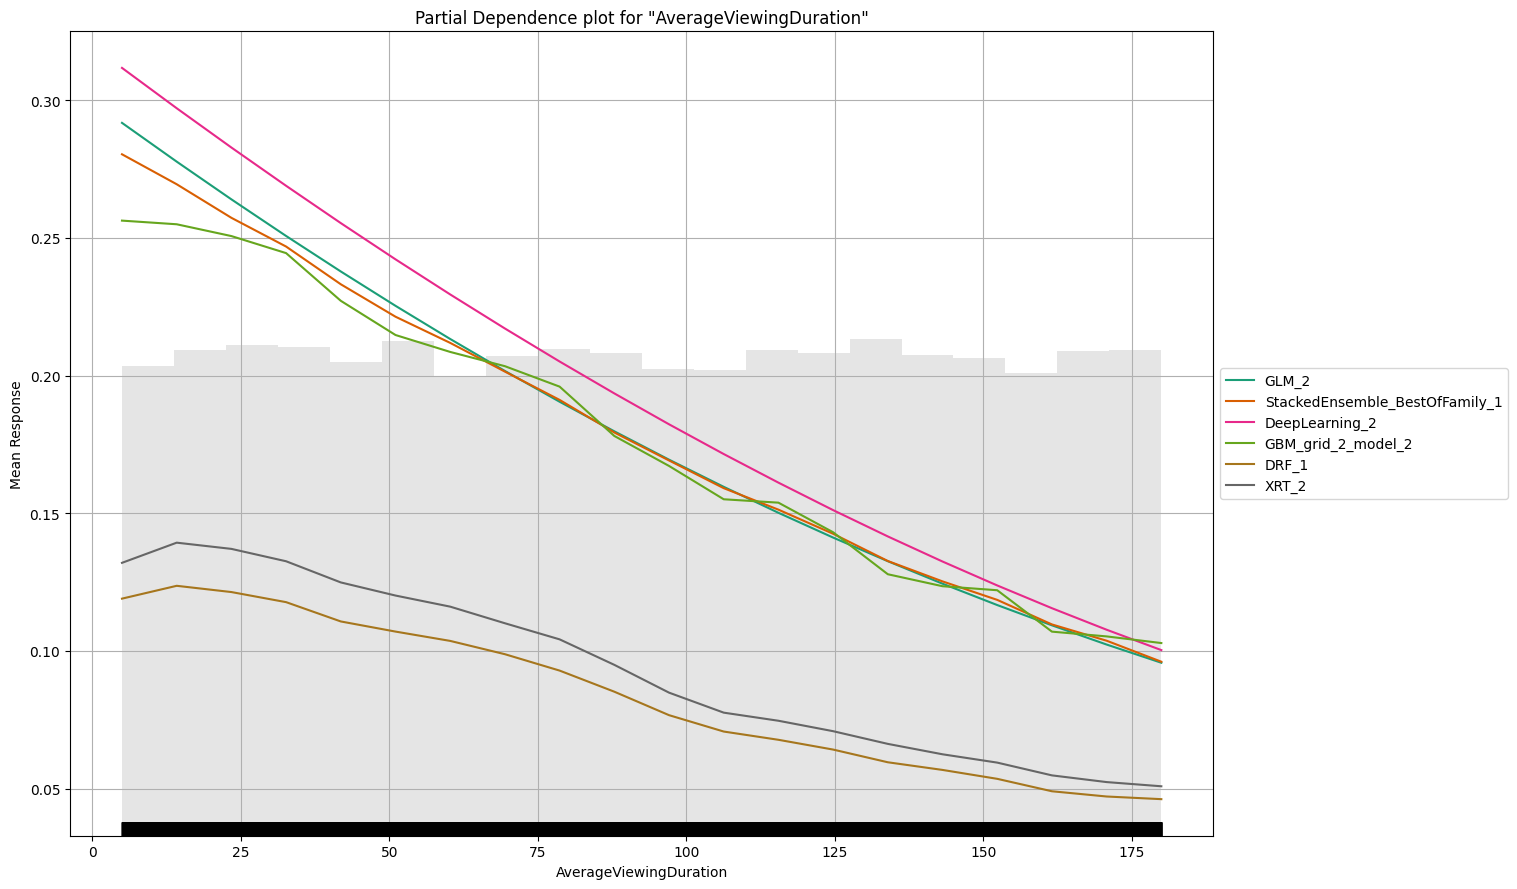

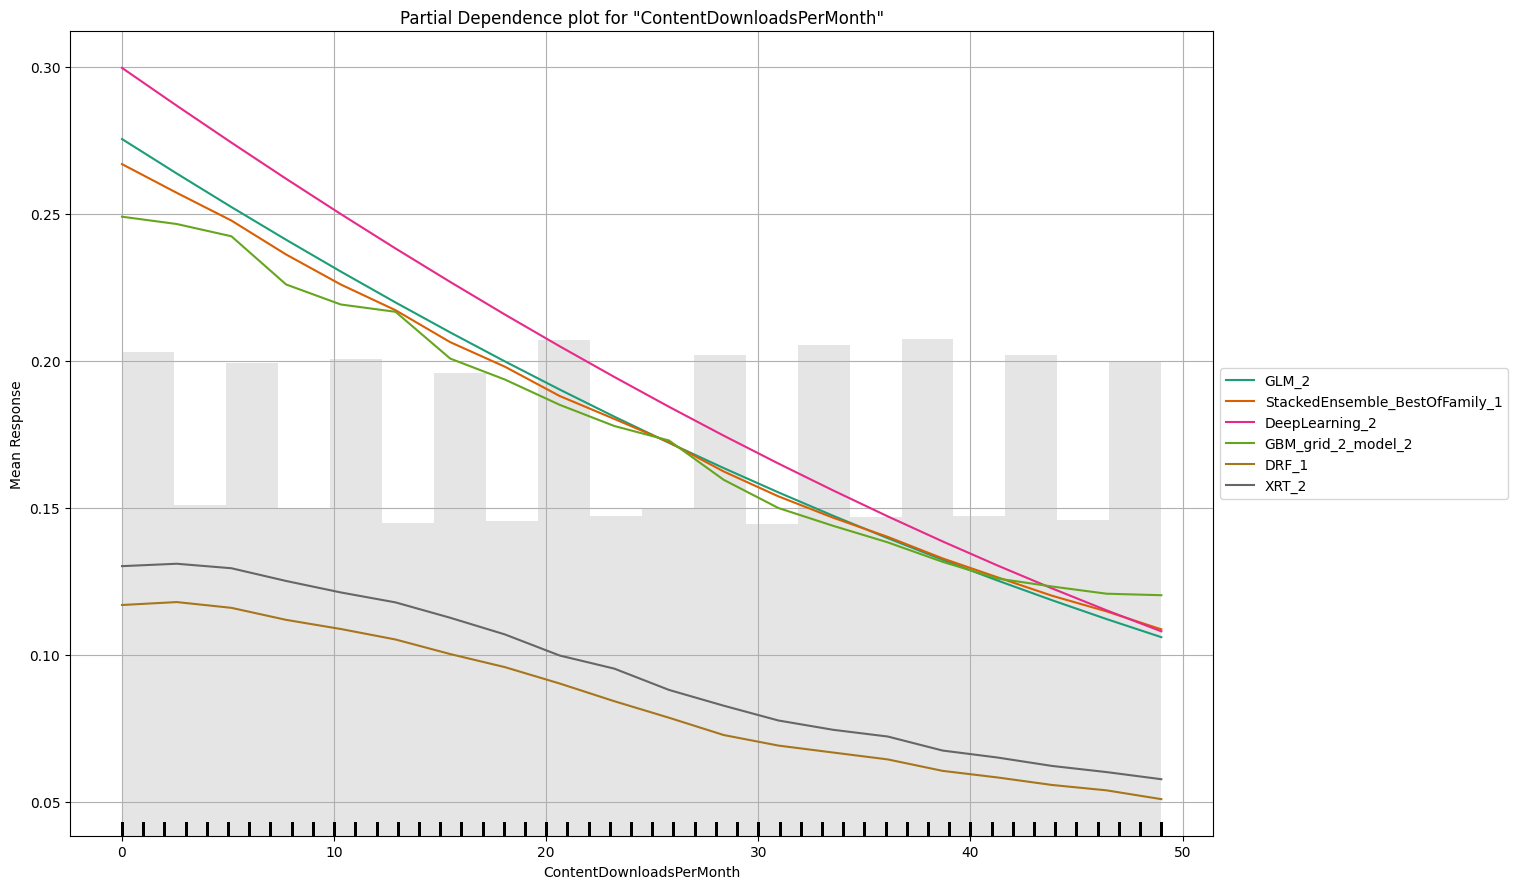

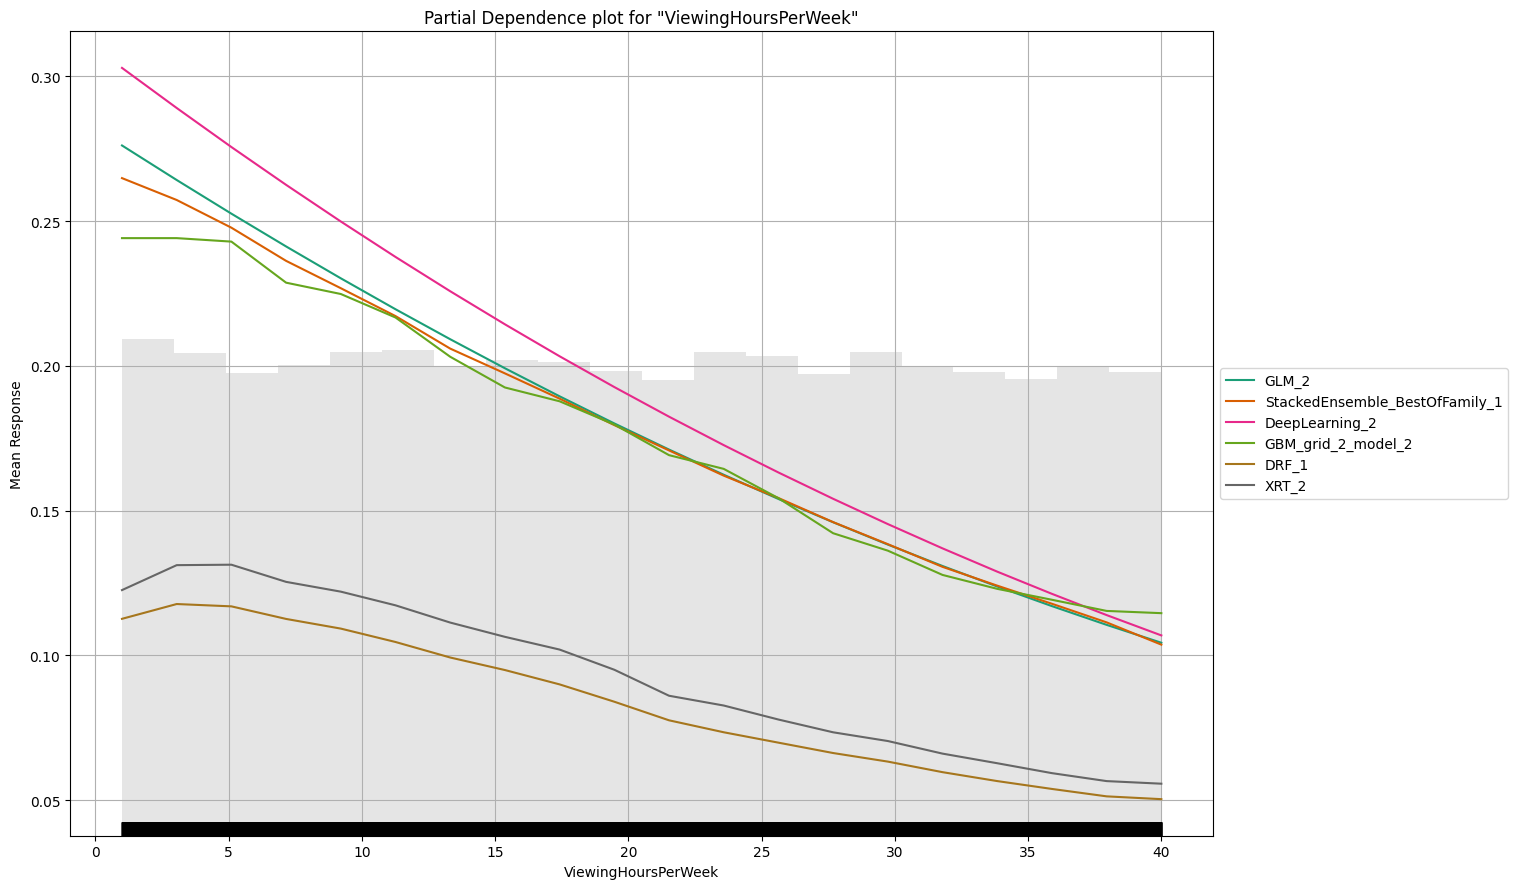

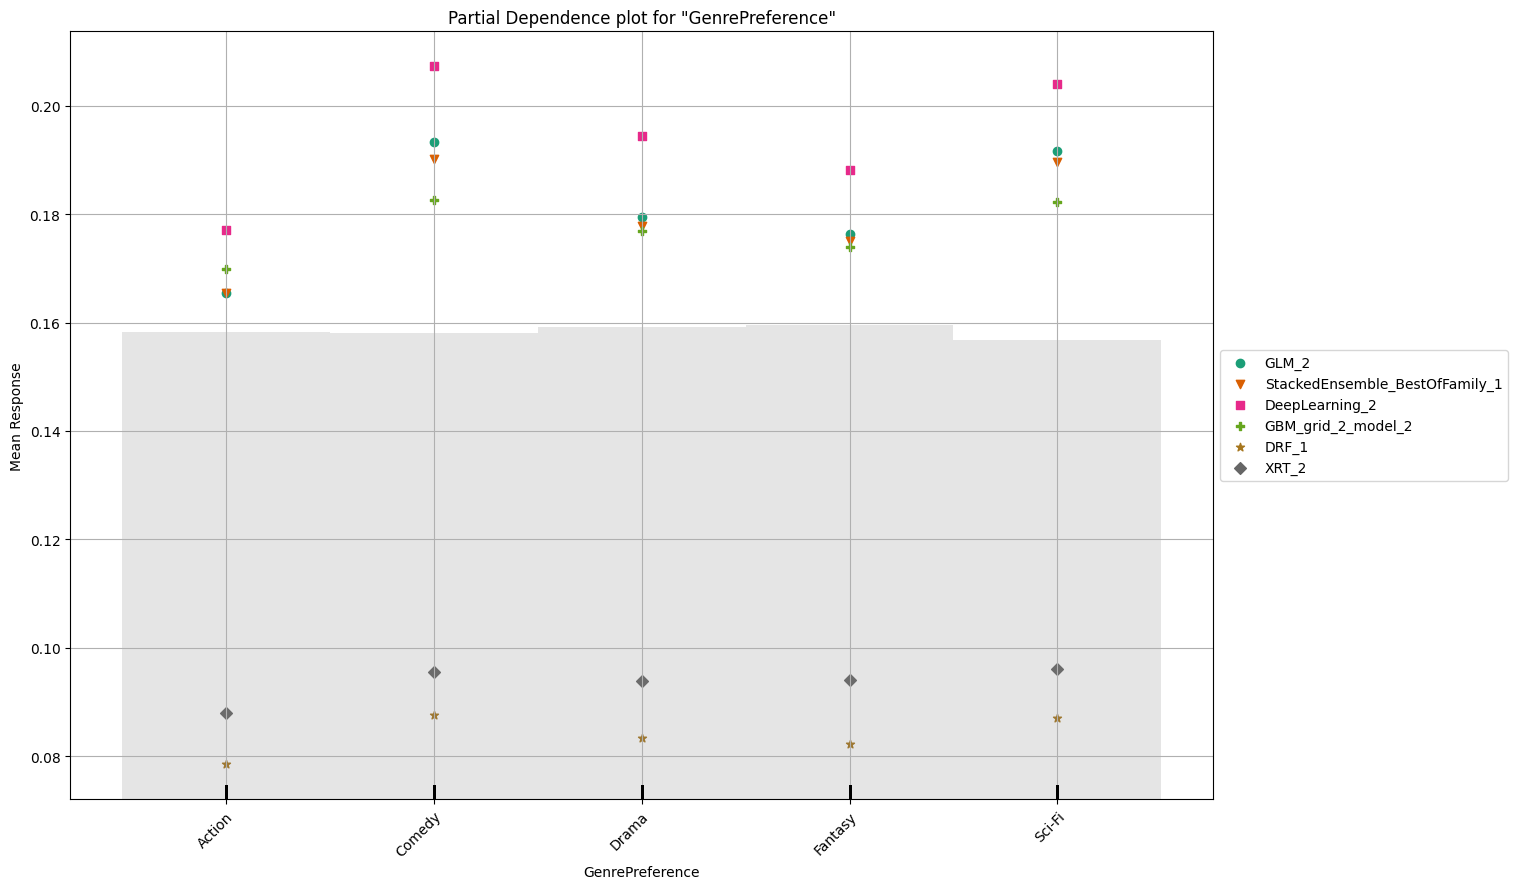

In [94]:
# Explain leader model & compare with all AutoML models
exa = aml.explain(X_y_val_h)

In [ ]:
# Explain a single H2O model (e.g. leader model from AutoML)
#exm = aml.leader.explain(test_h)

- Surprised that GLM performed better than stacked ensembles. Should try out other models.
- Recall is poor
- Even though, parameter was passed to balance both classes, H2o AutoML results weren't good
- AccountAge, AverageViewingDuration, ContentDownloadsPerMonth, ViewingHoursPerWeek, MonthlyCharges, SupportTicketsPerMonth are important features


In [75]:
# lets check target variable (Churn examples proportion) in train and val sets

y_train.sum()/len(y_train), y_val.sum()/len(y_val)




(0.18143455588656046, 0.18042167439189466)

In [ ]:
h2o.cluster().shutdown()

Let's try the following
- scaling features
- Cross validation
- Give class weights to deal with class imbalance and I prefer undersampling as we have enough data and oversampling may lead to overfitting especially with tree models
- random search or grid search for parameters with pipeline


In [170]:
def get_model(n_splits=5):
    cv = StratifiedKFold(**{
        'n_splits': n_splits,
        'shuffle': True,
        'random_state': 1
    })

    # recall_scorer = make_scorer(
    #     recall_score,
    #     greater_is_better=True,
    #     needs_proba=True
    #     )

    scoring = 'f1'

    scaler = MinMaxScaler()

    sampler = RandomUnderSampler(**{
        'random_state': 1
    })
    classifier = RandomForestClassifier(**{
        'random_state': 1,
        'n_jobs': -1,
        'verbose': 1
    })

    pipeline = Pipeline([
        ('scaler', scaler),
        ('sampler', sampler),
        ('classifier', classifier)
    ])

    param_grid = {
      'sampler__sampling_strategy': ['all', 'auto'], #all = resamples both classes, auto = resamples 'not minority' class so no of samples is equalized in both classes.
      'classifier__n_estimators': [50, 100], # no of trees
      'classifier__max_depth': [15, 20, 25, 30, 35, 40],
      'classifier__class_weight': ['balanced', None]


    }

    model = GridSearchCV(**{
        'estimator': pipeline,
        'cv': cv,
        'param_grid': param_grid,
        'verbose': 4,
        'scoring': scoring,
        'error_score': np.NaN,
        'n_jobs': -1
    })
    return model



In [171]:
model = get_model(n_splits=5)
model.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.2s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('sampler',
                                        RandomUnderSampler(random_state=1)),
                                       ('classifier',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=1,
                                                               verbose=1))]),
             n_jobs=-1,
             param_grid={'classifier__class_weight': ['balanced', None],
                         'classifier__max_depth': [15, 20, 25, 30, 35, 40],
                         'classifier__n_estimators': [50, 100],
                         'sampler__sampling_strategy': ['all', 'auto']},
             scoring='f1', verbose=4)

In [183]:
model.best_params_

{'classifier__class_weight': 'balanced',
 'classifier__max_depth': 15,
 'classifier__n_estimators': 100,
 'sampler__sampling_strategy': 'auto'}

In [174]:
y_pred = model.predict_proba(X_val)[:,1]



[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


In [175]:
y_val

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [187]:

precision, recall, thresholds = precision_recall_curve(y_val, y_pred, drop_intermediate=True)


In [188]:
score_df = pd.DataFrame([precision, recall, thresholds]).T

score_df.columns = ['precision','recall','thresholds']

score_df['f1_score'] = (2*score_df['precision']*score_df['recall'])/(score_df['precision']+score_df['recall'])
score_df.sort_values(by='f1_score', ascending=False)

pd.reset_option('display.max_rows')
score_df.sort_values(by='recall', ascending=False)

,precision,recall,thresholds,f1_score
0,0.180422,1.000000,0.038207,0.305690
1,0.180908,1.000000,0.082037,0.306388
2,0.180891,0.999886,0.082078,0.306358
3,0.181469,0.999886,0.096531,0.307187
4,0.181452,0.999773,0.096537,0.307158
...,...,...,...,...
15162,0.600000,0.000341,0.912258,0.000682
15163,0.500000,0.000227,0.918382,0.000454
15164,1.000000,0.000227,0.921420,0.000455
15165,1.000000,0.000114,0.946574,0.000227


Text(0.5, 0, 'Recall')

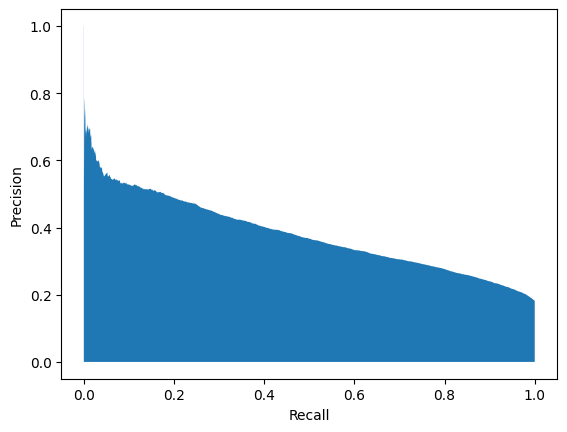

In [189]:
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")

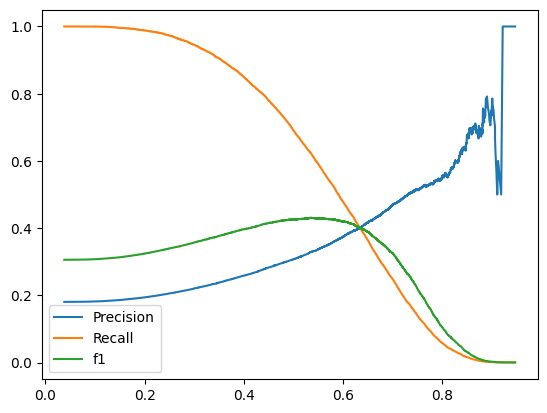

In [190]:
plt.plot(score_df.thresholds, score_df['precision'], label='Precision')
plt.plot(score_df.thresholds, score_df['recall'], label='Recall')
plt.plot(score_df.thresholds, score_df['f1_score'], label='f1')
plt.legend()

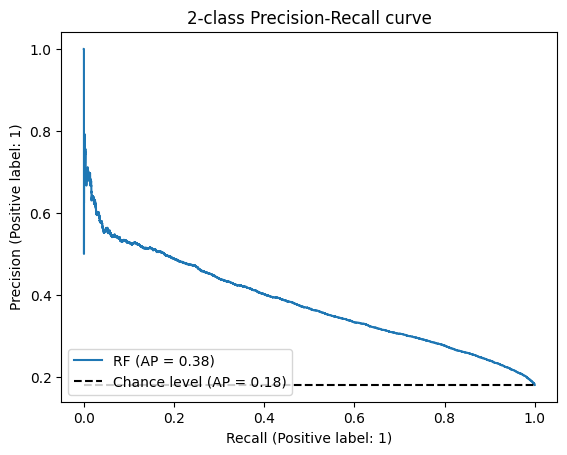

In [191]:
display = PrecisionRecallDisplay.from_predictions(
    y_val, y_pred, name="RF", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

Lets try XGBoost

In [77]:
# imbalance ratio = % of minority class examples/ % of majority class examples

IR = 0.18143455588656046/(1-0.18143455588656046)
IR

# positive_instances = sum(y_train == 1)
# negative_instances = sum(y_train == 0)
# positive_instances, negative_instances
# negative_instances/positive_instances



0.22164941995940968

In [83]:
def get_model(n_splits=5):

    cv = StratifiedKFold(**{
        'n_splits': n_splits,
        'shuffle': True,
        'random_state': 1
    })

    # recall_scorer = make_scorer(
    #     recall_score,
    #     greater_is_better=True,
    #     needs_proba=True
    #     )

    scoring = 'f1_macro'

    scaler = MinMaxScaler()

    sampler = RandomUnderSampler(**{
        'random_state': 1
    })

    classifier = XGBClassifier(**{
        'random_state': 1,
        'n_jobs': -1,
        'verbosity': 2,
        'validate_parameters': True,
        'disable_default_eval_metric': True,
        'eval_metric' : 'aucpr',
        'scale_pos_weight' : 1/IR # Since scale_pos_weight quantifies the cost of a false negative, we set its value to the inverse of the imbalance ratio.
    })

    pipeline = Pipeline([
        ('scaler', scaler),
        ('sampler', sampler),
        ('classifier', classifier)
    ])

    param_grid = {
      'sampler__sampling_strategy': ['all', 'auto'], #all = resamples both classes, auto = resamples 'not minority' class so no of samples is equalized in both classes.
      'classifier__n_estimators': [25, 50, 100, 125, 150, 200], # no of trees
      'classifier__max_depth': [3, 6, 9, 12, 15, 18, 20, 25, 30, 35],
      'classifier__eta' : [0.001, 0.01, 0.1, 1],
      'classifier__min_child_weight' : [1, 3, 5, 7],
      'classifier__max_delta_step' : [0, 1, 3, 5], #needed when imbalance exists
      'classifier__subsample' : [0.5, 0.75, 1], # 0.75 for preventing overfitting
      'classifier__alpha' : [0, 1, 3, 5, 10, 15], # L1 regularization. Can act as in-built feature selection as we have seen many unimportant features
      'classifier__colsample_bytree' : [0.3, 0.4, 0.5 , 0.7, 0.9],
      'classifier__gamma' : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ]
    }

    model = RandomizedSearchCV(**{
        'estimator': pipeline,
        'cv': cv,
        'param_distributions': param_grid,
        'verbose': 4,
        'scoring': scoring,
        'error_score': np.NaN,
        'n_jobs': -1,
        'random_state' : 2
    })
    return model



In [84]:
model = get_model(n_splits=3)
model.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[16:31:45] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 2646 extra nodes, 0 pruned nodes, max_depth=20
[16:31:45] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 3670 extra nodes, 10 pruned nodes, max_depth=20
[16:31:45] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 4080 extra nodes, 8 pruned nodes, max_depth=20
[16:31:46] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\tree\updater_prune.cc:98: tree pruning end, 5348 extra nodes, 112 pruned nodes, max_depth=20
[16:31:46] INFO: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=1, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                             ('sampler',
                                              RandomUnderSampler(random_state=1)),
                                             ('classifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            disable_default_eval_metric=True,
                                                            e...
                                        'classifier__gamma': [0.0, 0.1, 0.2,
                                                              0.3, 0.4],
                                        'classifier__max_delta_step': [0, 1, 3,
                                                                       5],
                                        'classifier__max_depth': [3, 6, 9, 12,
                                                                  15, 18, 20,
                                                                  25, 30, 35],
                                        'classifier__min_child_weight': [1, 3,
                                                                         5, 7],
                                        'classifier__n_estimators': [25, 50,
                                                                     100, 125,
                                                                     150, 200],
                                        'classifier__subsample': [0.5, 0.75, 1],
                                        'sampler__sampling_strategy': ['all',
                                                                       'auto']},
                   random_state=2, scoring='f1_macro', verbose=4)

In [85]:
model.best_params_

{'sampler__sampling_strategy': 'all',
 'classifier__subsample': 1,
 'classifier__n_estimators': 200,
 'classifier__min_child_weight': 1,
 'classifier__max_depth': 20,
 'classifier__max_delta_step': 1,
 'classifier__gamma': 0.1,
 'classifier__eta': 0.1,
 'classifier__colsample_bytree': 0.9,
 'classifier__alpha': 1}

In [86]:
y_pred = model.predict_proba(X_val)[:,1]
precision, recall, thresholds = precision_recall_curve(y_val, y_pred, drop_intermediate=True)

In [87]:
score_df = pd.DataFrame([precision, recall, thresholds]).T

score_df.columns = ['precision','recall','thresholds']

score_df['f1_score'] = (2*score_df['precision']*score_df['recall'])/(score_df['precision']+score_df['recall'])
score_df.sort_values(by='f1_score', ascending=False)

pd.reset_option('display.max_rows')
score_df.sort_values(by='f1_score', ascending=False)

,precision,recall,thresholds,f1_score
6378,0.322403,0.612482,0.761829,0.422439
6380,0.322382,0.612368,0.761850,0.422394
6368,0.322182,0.613050,0.761206,0.422384
6379,0.322363,0.612368,0.761830,0.422377
6376,0.322270,0.612595,0.761573,0.422352
...,...,...,...,...
15276,0.600000,0.000341,0.998098,0.000682
15279,1.000000,0.000227,0.998769,0.000455
15278,0.666667,0.000227,0.998546,0.000455
15280,1.000000,0.000114,0.998986,0.000227


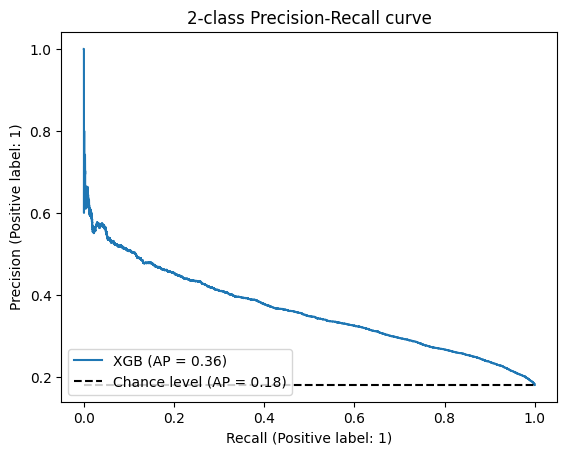

In [88]:
display = PrecisionRecallDisplay.from_predictions(
    y_val, y_pred, name="XGB", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

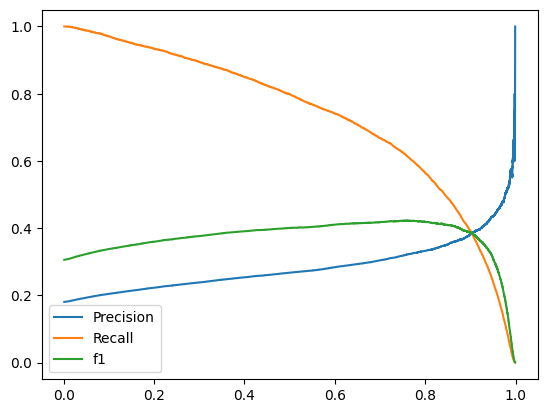

In [89]:
plt.plot(score_df.thresholds, score_df['precision'], label='Precision')
plt.plot(score_df.thresholds, score_df['recall'], label='Recall')
plt.plot(score_df.thresholds, score_df['f1_score'], label='f1')
plt.legend()

In [90]:
score_df.sort_values(by='f1_score', ascending = False)

,precision,recall,thresholds,f1_score
6378,0.322403,0.612482,0.761829,0.422439
6380,0.322382,0.612368,0.761850,0.422394
6368,0.322182,0.613050,0.761206,0.422384
6379,0.322363,0.612368,0.761830,0.422377
6376,0.322270,0.612595,0.761573,0.422352
...,...,...,...,...
15276,0.600000,0.000341,0.998098,0.000682
15279,1.000000,0.000227,0.998769,0.000455
15278,0.666667,0.000227,0.998546,0.000455
15280,1.000000,0.000114,0.998986,0.000227


We got similar results with Random Forest and XGBoost. Let's use XGBoost as it is less intensive and learns from past mistakes. Assuming that the business wants to proceed with threshold at maximum f1_score.

In [91]:
churn_decision_threshold = round(score_df.sort_values(by='f1_score', ascending=False)['thresholds'].reset_index(drop=True)[0],2)
churn_decision_threshold

0.76

Getting predictions for test set

In [97]:
# one hot encoding the categorical variables
test_dict = test.to_dict(orient='records')
X_test = dv.transform(test_dict)
y_pred = model.predict_proba(X_test)[:,1]
y_pred
y_pred = y_pred>0.76

y_pred

array([False, False,  True, ..., False,  True, False])

In [ ]:
def get_predictions(df, decision_threshold = 0.76):

    dv = DictVectorizer(sparse=False)
    test_dict = df.to_dict(orient='records')
    X_test = dv.transform(test_dict)
    y_pred = model.predict_proba(X_test)[:,1]
    pred_decisions = (y_pred >= decision_threshold).astype(int)
    return y_pred, pred_decisions

